<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/FacialKeypointInception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
!pip install --upgrade --force-reinstall --no-deps -q -U albumentations
!pip install --upgrade --force-reinstall --no-deps -q -U opencv-python
!pip install qudida

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [139]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob
import concurrent.futures
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

In [140]:
class TqdmUpTo(tqdm):
  def update_to(self, b=1, bsize=1, tsize=None):
    if tsize is not None:
      self.total = tsize
    self.update(b*bsize-self.n)

In [141]:
def download_url(url, filepath):
  directory = os.path.dirname(os.path.abspath(filepath))
  os.makedirs(directory, exist_ok=True)
  if os.path.exists(filepath):
    print('Filepath already exists, Skipping download')
    return

  with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
    urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
    t.total = t.n

def extract_archive(filepath):
  extract_dir = os.path.dirname(os.path.abspath(filepath))
  shutil.unpack_archive(filepath, extract_dir)

In [142]:
dataset_directory = os.path.join(os.environ['HOME'], 'datasets/facial-recognition')

In [143]:
filepath = os.path.join(dataset_directory, 'facial-keypoints-detection.zip')
download_url(
    url="https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3486/31310/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1657175717&Signature=hkEDpgY0EHo3UC%2FfSXZsWPWja%2B%2FxJIwmvQiolb4no34yFe7GYvfD5Suix3UYanB6Fs%2FG1BsdY52JfA8v%2F7PSmRUOChPCB6ZRmEVipQ9wp1Yrc%2BbzPMCVEmg3s1abJhKhodNSOMce%2F%2FAb0%2FwXOXR7KKIQ%2BVWiCQ9ohvkXlAOrFCzMTd5AGpHtcGSuXHSr4GLNSCjuxWx6kyOiTj%2B7CvIFctYH8itrUMe5I16OMaVWqUlG6qnjfRcW%2F%2BD2YlbM0EhB3fFTxWGcfXb1ir6zerNjW54Dww5J54MInmlZES5hXBvg1mVPhD7mCUFXvYGWM%2FQP510JZv1StJM71Y8ZdzK5yg%3D%3D&response-content-disposition=attachment%3B+filename%3Dfacial-keypoints-detection.zip",
    filepath=filepath,
)
extract_archive(filepath)

Filepath already exists, Skipping download


In [144]:
!ls /root/datasets/facial-recognition

facial-keypoints-detection.zip	test.csv      training.zip
IdLookupTable.csv		test.zip
SampleSubmission.csv		training.csv


In [145]:
training_path = os.path.join(dataset_directory, 'training.zip')
test_path = os.path.join(dataset_directory, 'test.zip')

extract_archive(training_path)
extract_archive(test_path)

In [146]:
!ls /root/datasets/facial-recognition

facial-keypoints-detection.zip	test.csv      training.zip
IdLookupTable.csv		test.zip
SampleSubmission.csv		training.csv


In [147]:
training_path = os.path.join(dataset_directory, 'training.csv')
test_path = os.path.join(dataset_directory, 'test.csv')
key_pts_frame = pd.read_csv(training_path)
test_key = pd.read_csv(test_path)
key_pts_frame.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [148]:
key_pts_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [149]:
test_key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [150]:
key_pts_frame.fillna(method = 'ffill', inplace=True)

In [151]:
imag = []

for i in range(7049):
  img = key_pts_frame['Image'][i].split(' ')
  img = ['0' if x == '' else x for x in img]
  imag.append(img)

In [152]:
image_list = np.array(imag, dtype='float')
X_train = image_list.reshape(-1, 96, 96, 1)

In [153]:
imag = []

for i in range(1783):
  img = test_key['Image'][i].split(' ')
  img = ['0' if x == '' else x for x in img]
  imag.append(img)

In [154]:
image_list = np.array(imag, dtype='float')
X_test = image_list.reshape(-1, 96, 96, 1)

In [155]:
X_train.shape

(7049, 96, 96, 1)

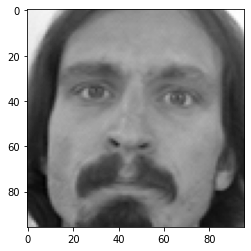

In [156]:
plt.imshow(X_train[0].reshape(96, 96), cmap='gray')

In [157]:
training = key_pts_frame.drop('Image', axis=1)

y_train = []
for i in range(7049):
  y = training.iloc[i, :]

  y_train.append(y)

y_train = np.array(y_train, dtype='float')

In [158]:
y_train[0]

array([66.03356391, 39.00227368, 30.22700752, 36.4216782 , 59.58207519,
       39.64742256, 73.13034586, 39.96999699, 36.35657143, 37.3894015 ,
       23.45287218, 37.3894015 , 56.95326316, 29.03364812, 80.22712782,
       32.22813835, 40.22760902, 29.0023218 , 16.35637895, 29.64747068,
       44.42057143, 57.06680301, 61.19530827, 79.97016541, 28.61449624,
       77.38899248, 43.3126015 , 72.93545865, 43.13070677, 84.48577444])

In [159]:
def visualize_keypoints(image, key_pts):

  keypoints = np.array(key_pts, dtype='float').reshape(-1, 2)

  plt.imshow(image, 'gray')
  plt.scatter(keypoints[:, 0], keypoints[:, 1], s=100, marker='.', c='m')
  plt.axis('off')
  plt.show()

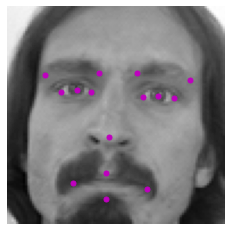

In [160]:
visualize_keypoints(np.squeeze(X_train[0]), y_train[0])

In [161]:
class FacialKeypointsDataset(Dataset):
  def __init__(self, X_train, y_train, transform=None):
    self.images = X_train
    self.keypoints = y_train
    self.transform = transform

  def __len__(self):
    return len(self.keypoints)

  def __getitem__(self, idx):
    img = self.images[idx].reshape(96, 96)
    keypoint = self.keypoints[idx]

    img = img/255.0
    img = np.array(img, dtype=np.float32)
    # img = img.transpose((2, 0, 1))

    # img = img.type(torch.FloatTensor)

    keypoint = np.array(keypoint, dtype=np.float32).reshape(-1, 2)

    if self.transform:
      transformed = self.transform(image=img, keypoints=keypoint)
      transformed['keypoints'] = np.array(transformed['keypoints'], dtype=np.float32).reshape(-1, 2)
      img = transformed['image']
      keypoint = transformed['keypoints']

    keypoint = (keypoint - 100)/50
    keypoint = torch.from_numpy(keypoint)
    keypoint = keypoint.view(-1)
    keypoint = keypoint.type(torch.FloatTensor)

    return img, keypoint

In [162]:
from albumentations.augmentations.geometric.resize import Resize
train_transform = A.Compose([
                             A.Rotate(limit=25),
                             A.Resize(height=224, width=224),
                             A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
                             A.RandomBrightnessContrast(p=0.5),
                             ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

training_dataset = FacialKeypointsDataset(X_train, y_train, transform=train_transform)

In [163]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

In [164]:
class inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(inception_block, self).__init__()

    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
    )

    self.branch3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size=1),
        conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        conv_block(in_channels, out_1x1pool, kernel_size=1)
    )

  def forward(self, x):
    return torch.cat(
        [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
    )

In [165]:
class GoogLeNet(nn.Module):
  def __init__(self, num_classes=30):
    super(GoogLeNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7,7), stride=(2, 2), padding=(3, 3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)

    x = self.inception5a(x)
    x = self.inception5b(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)

    return x

In [166]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogLeNet().to(device)
print(model)

GoogLeNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): 

In [167]:
batch_size = 64
learning_rate = 0.003
epochs = 30

In [168]:
!pip install madgrad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [169]:
from madgrad import MADGRAD

In [170]:
criterion = nn.MSELoss()
optimizer = MADGRAD(model.parameters(), lr=learning_rate)

In [171]:
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

In [172]:
def train(epochs):
  model.train()
  losses = np.zeros(epochs)

  best_model = 1000

  for i in range(epochs):
    train_loss = []

    for idx, (img, labels) in enumerate(train_loader):

      optimizer.zero_grad()

      img = img.type(torch.FloatTensor)
      labels = labels.type(torch.FloatTensor)

      img, labels = img.to(device), labels.to(device)
      score = model(img)
      loss = criterion(score, labels)

      train_loss.append(loss.item())
      loss.backward()
      optimizer.step()

    train_loss = np.mean(train_loss)
    losses[i] = train_loss

    print(f'Epoch: {i+1}, Loss: {train_loss:.4f}')

    torch.save(model.state_dict(), f'model{i+1}.pt')

    if best_model > train_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      best_model = train_loss
      print('Model Saved!')

  return losses

In [173]:
losses = train(epochs)

Epoch: 1, Loss: 0.1014
Model Saved!
Epoch: 2, Loss: 0.0435
Model Saved!
Epoch: 3, Loss: 0.0352
Model Saved!
Epoch: 4, Loss: 0.0289
Model Saved!
Epoch: 5, Loss: 0.0268
Model Saved!
Epoch: 6, Loss: 0.0242
Model Saved!
Epoch: 7, Loss: 0.0236
Model Saved!
Epoch: 8, Loss: 0.0208
Model Saved!
Epoch: 9, Loss: 0.0202
Model Saved!
Epoch: 10, Loss: 0.0189
Model Saved!
Epoch: 11, Loss: 0.0195
Epoch: 12, Loss: 0.0177
Model Saved!
Epoch: 13, Loss: 0.0185
Epoch: 14, Loss: 0.0183
Epoch: 15, Loss: 0.0174
Model Saved!
Epoch: 16, Loss: 0.0158
Model Saved!
Epoch: 17, Loss: 0.0159
Epoch: 18, Loss: 0.0151
Model Saved!
Epoch: 19, Loss: 0.0156
Epoch: 20, Loss: 0.0141
Model Saved!
Epoch: 21, Loss: 0.0139
Model Saved!
Epoch: 22, Loss: 0.0129
Model Saved!
Epoch: 23, Loss: 0.0131
Epoch: 24, Loss: 0.0134
Epoch: 25, Loss: 0.0128
Model Saved!
Epoch: 26, Loss: 0.0127
Model Saved!
Epoch: 27, Loss: 0.0124
Model Saved!
Epoch: 28, Loss: 0.0117
Model Saved!
Epoch: 29, Loss: 0.0124
Epoch: 30, Loss: 0.0116
Model Saved!


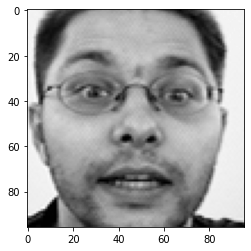

In [174]:
plt.imshow(X_test[0].reshape(96, 96), 'gray')

In [175]:
model = GoogLeNet().to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

GoogLeNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): 

In [176]:
y_test = np.copy(y_train)
X_test.shape

(1783, 96, 96, 1)

In [177]:
y_test = y_test[:1783]
y_test.shape

(1783, 30)

In [178]:
def get_keypoints(img):
  model.eval()

  with torch.no_grad():
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    img = img.reshape(1, img.shape[0], img.shape[1])
    img = img/255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.type(torch.FloatTensor)
    img = img.to(device)

    score = model(img)
    score = score.cpu().numpy()
    score = score*50+100
    return score

In [232]:
def get_images(img):
  img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
  return img

In [179]:
def test_from_data(img):
  key = get_keypoints(img)
  resized = cv2.resize(np.squeeze(img), (224, 224), interpolation = cv2.INTER_AREA)
  visualize_keypoints(resized, key)

In [180]:
key = get_keypoints(X_train[2])
print(key)

[[146.53265   81.25465   68.82024   81.98922  134.3364    85.49228
  161.34189   85.71973   81.935295  84.67012   55.432117  85.05632
  128.48119   66.98129  175.49556   68.815216  89.57591   66.50551
   41.55672   68.3613   109.24091  123.36996  137.17099  170.15504
   79.50099  170.26404  108.46709  158.56418  108.30709  184.21353 ]]


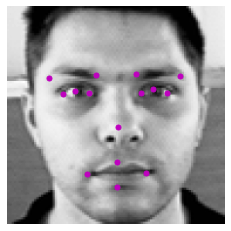

In [181]:
test_from_data(X_train[3])

In [182]:
!ls /root/datasets/facial-recognition

facial-keypoints-detection.zip	test.csv      training.zip
IdLookupTable.csv		test.zip
SampleSubmission.csv		training.csv


In [183]:
lookup = pd.read_csv(os.path.join(dataset_directory, 'IdLookupTable.csv'))
sample_submission = pd.read_csv(os.path.join(dataset_directory, 'SampleSubmission.csv'))

lookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [184]:
sample_submission.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [244]:
location = []

change_img = A.Compose([A.Resize(96, 96),],
                       keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [245]:
for i in X_test:
  location.append(get_keypoints(i).flatten())

In [246]:
location = np.array(location, dtype='float')
location.shape

(1783, 30)

In [223]:
X_test.shape

(1783, 96, 96, 1)

In [235]:
gambar = []

for i in range(len(X_test)):
  gambar.append(get_images(X_test[i]))

gambar = np.array(gambar, dtype='float')

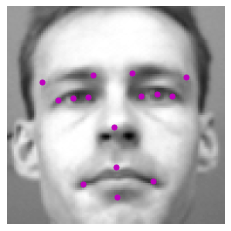

In [239]:
test_from_data(gambar[3])

In [250]:
labeling = []
images = []

for img, labels in zip(gambar, location):
  labels = labels.reshape(-1, 2)
  transformed = change_img(image=img, keypoints=labels)

  images.append(transformed['image'])
  transformed['keypoints'] = np.array(transformed['keypoints'], dtype='float').flatten()
  labeling.append(transformed['keypoints'])

labeling = np.array(labeling, dtype='float')
images = np.array(images, dtype='float')

In [251]:
labeling = np.array(labeling)

In [252]:
labeling.shape

(1783, 30)

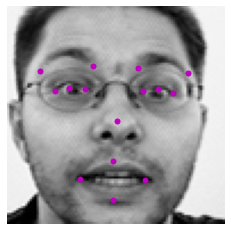

In [253]:
visualize_keypoints(np.squeeze(X_test[0]), labeling[0])

In [255]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   RowId     27124 non-null  int64
 1   Location  27124 non-null  int64
dtypes: int64(2)
memory usage: 423.9 KB


In [256]:
labeling.shape

(1783, 30)

In [257]:
feature_names = list(lookup['FeatureName'])
image_ids = list(lookup['ImageId']-1)
row_ids = list(lookup['RowId'])

In [258]:
feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    print(feature)
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(labeling[x][y])
    #print(y)

Output streaming akan dipotong hingga 5000 baris terakhir.
left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
nose_tip_x
nose_tip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
nose_tip_x
nose_tip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
nose_tip_x
nose_tip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
nose_tip_x
nose_tip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
nose_tip_x
nose_tip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
nose_tip_x
nose_tip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y
left_eye_center_x
left_eye_center_y
right_eye_center_

In [259]:
predictions = np.array(predictions)
predictions.shape

(27124,)

In [260]:
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
print(locations)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

0        65.906080
1        35.938526
2        26.769174
3        35.497510
4        59.353683
           ...    
27119    38.206895
27120    46.185889
27121    61.764274
27122    46.758535
27123    78.018808
Name: Location, Length: 27124, dtype: float64
